In [2]:
import numpy as np
import pandas as pd
from scipy.special import iv
from scipy import integrate
from datetime import datetime, timedelta
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

In [3]:
def calculate_probability(ro, a, b, t, sigma1 = 1, sigma2 = 1, n_terms=100):
    # Helper function to compute alpha based on r
    def alpha(ro):
        if ro > 0:
            return np.pi + np.arctan(-np.sqrt(1 - ro**2) / ro)
        elif ro == 0:
            return np.pi / 2
        else:
            return np.arctan(-np.sqrt(1 - ro**2) / ro)
        
    def theta0(Z1, Z2, ro):
        if Z1 < ro*Z2:
            tmp = Z2*np.sqrt(1-ro**2) / (Z1 - ro*Z2)
            return np.pi + np.arctan(tmp)
        elif Z1 == ro*Z2:
            return np.pi / 2
        else:
            tmp = Z2*np.sqrt(1-ro**2) / (Z1 - ro*Z2)
            return np.arctan(tmp)
    Z1 = a / sigma1
    Z2 = b / sigma2
    theta0_val = theta0(Z1, Z2, ro)
    r0 = Z2 / np.sin(theta0_val)
    # print(f'r0: {r0}')

    # theta0_val = np.pi/2
    alpha_val = alpha(ro)

    summation_result = 0

    for n in range(1, 2 * n_terms + 1, 2):  # Only sum over odd n
        v_n = n * np.pi / alpha_val
        iv_1 = iv((v_n - 1)/2, (r0**2) / (4 * t))
        iv_2 = iv((v_n + 1)/2, (r0**2) / (4 * t))
        if np.abs(iv_1 + iv_2) < 1e-100:
            break
        summation_result += (1/n) * np.sin(n * np.pi * theta0_val / alpha_val) * \
                            (iv((v_n - 1)/2, (r0**2) / (4 * t)) + iv((v_n + 1)/2, (r0**2) / (4 * t)))

    # Compute the final probability
    probability = (2 * r0 / np.sqrt(2 * np.pi * t)) * np.exp(-r0**2 / (4 * t)) * summation_result

    return probability

In [4]:
class MixedDerivative:
    def __init__(self, func):
        self.func = func

    def approx_derivative(self, x, y, dx=1e-3, dy=1e-3):
        f_xy = self.func(x + dx, y + dy)
        f_x_y = self.func(x + dx, y - dy)
        f_x_y_ = self.func(x - dx, y + dy)
        f__xy = self.func(x - dx, y - dy)

        # print('f_xy: ', f_xy)
        # print('f_x_y: ', f_x_y)
        # print('f_x_y_: ', f_x_y_)
        # print('f__xy: ', f__xy)
        # print('4 * dx * dy; ', 4 * dx * dy)

        derivative = (f_xy - f_x_y - f_x_y_ + f__xy) / (4 * dx * dy)
        return derivative

In [5]:
def rho_calculation(rate1, rate2):

    price1 = np.log(rate1.price)
    price2 = np.log(rate2.price)
    price1_diff = np.diff(price1) / np.std(np.diff(price1))
    price2_diff = np.diff(price2) / np.std(np.diff(price2))

    rho = np.cov(price1_diff, price2_diff)[0][1] / np.std(price2_diff)**2
    return rho

In [6]:
wbtc_usd_rate = pd.read_csv('wbtc-usd-till-Jan22.csv')
eth_usd_rate = pd.read_csv('eth-usd-till-Jan22.csv')

In [20]:
wbtc_usd_rate = wbtc_usd_rate[pd.to_datetime(wbtc_usd_rate['snapped_at']) >= pd.to_datetime('2021-09-06 00:00:00 UTC')]
eth_usd_rate = eth_usd_rate[pd.to_datetime(eth_usd_rate['snapped_at']) >= pd.to_datetime('2021-09-06 00:00:00 UTC')]

rho = rho_calculation(eth_usd_rate, wbtc_usd_rate)

In [60]:
df_eth_a = pd.read_csv('df_eth_a_with_x_min.csv')
df_wbtc_a = pd.read_csv('df_wbtc_a_with_x_min.csv')

In [61]:
df_eth_a_without_nan = df_eth_a[~np.isnan(df_eth_a['x_min'])]
df_wbtc_a_without_nan = df_wbtc_a[~np.isnan(df_wbtc_a['x_min'])]

In [ ]:
df_eth_a_without_nan['timestamp_new'] = df_eth_a_without_nan['timestamp'].apply(lambda x: x.split(' ')[0])
df_wbtc_a_without_nan['timestamp_new'] = df_wbtc_a_without_nan['timestamp'].apply(lambda x: x.split(' ')[0])

In [27]:
df1 = df_wbtc_a_without_nan.sort_values(by=['timestamp'])
df2 = df_eth_a_without_nan.sort_values(by=['timestamp'])

## Dictionary (x_min -- debt) preparation

In [70]:
debt_status_eth_a = pd.read_csv('debt_status_eth_a.csv')
debt_status_wbtc_a = pd.read_csv('debt_status_wbtc_a.csv')

In [131]:
def avg_time_debt_calculation(df1, df2, debt_status1, debt_status2):
    avg_time = 0
    for user in df1.usr.unique():
        df_status_user = debt_status1[debt_status1['usr'] == user]
        date = pd.to_datetime(df1[df1['usr'] == user].timestamp.iloc[0])
        for i in range(df_status_user.shape[0]):
            row = df_status_user.iloc[i]
            if (date >= pd.to_datetime(row.start_date)) & (date <= pd.to_datetime(row.end_date)):
                avg_time += (pd.to_datetime(row.end_date) - pd.to_datetime(row.start_date)).days
    
    for user in df2.usr.unique():
        df_status_user = debt_status2[debt_status2['usr'] == user]
        date = pd.to_datetime(df2[df2['usr'] == user].timestamp.iloc[0])
        for i in range(df_status_user.shape[0]):
            row = df_status_user.iloc[i]
            if (date >= pd.to_datetime(row.start_date)) and (date <= pd.to_datetime(row.end_date)):
                avg_time += (pd.to_datetime(row.end_date) - pd.to_datetime(row.start_date)).days
    return avg_time / (len(df1.usr) + len(df2.usr))

In [72]:
avg_time = avg_time_debt_calculation(df_wbtc_new, df_eth_new, debt_status_wbtc_a, debt_status_eth_a)

In [ ]:
def dict_x_min_debt_creation(df):

    res = {}
    for i in range(df.shape[0]):
        row = df.iloc[i]
        res[row.x_min] = row.debt
    
    res = dict(sorted(res.items()))
    return res, np.sum(list(res.values()))

dict_wbtc, overall_debt_wbtc = dict_x_min_debt_creation(df_wbtc_new)
dict_eth, overall_debt_eth = dict_x_min_debt_creation(df_eth_new)




def calculate_joint_prob(y, x, overall_debt_1, overall_debt_2, rho, T):
    
    res = {}
    additional_default_1 = np.sum(np.where(np.array(list(x.keys()))<0, np.array(list(x.values())), 0))      # it means that there is always user who default
    additional_default_2 = np.sum(np.where(np.array(list(y.keys()))<0, np.array(list(y.values())), 0))

    def delete_negative_x_min(x_min_arr):
        for key in list(x_min_arr.keys()):
            if key < 0:
                x_min_arr.pop(key)
        return x_min_arr
    
    x = delete_negative_x_min(x)
    y = delete_negative_x_min(y)

    for k in tqdm(range(-1, len(x), 1)):
        default_money_1 = 0
        a, b, c, d = 0, 0, 0, 0

        if k == -1:
            a = 0
            b = list(x.keys())[0]
        elif k == len(x) - 1:
            a = list(x.keys())[k]
            b = list(x.keys())[k] + 10
            default_money_1 = np.sum(list(x.values())) + additional_default_1
        else:
            a = list(x.keys())[k] 
            b = list(x.keys())[k+1]
            default_money_1 = np.sum(list(x.values())[:k]) + additional_default_1

        for l in range(-1, len(y), 1):
            default_money_2 = 0

            if l == -1:
                c = 0
                d = list(y.keys())[0]
            elif l == len(y) - 1:
                c = list(y.keys())[l]
                d = list(y.keys())[l] + 10
                default_money_2 = np.sum(list(y.values())) + additional_default_2
            else:
                c = list(y.keys())[l]
                d = list(y.keys())[l+1]
                default_money_2 = np.sum(list(y.values())[:l]) + additional_default_2
            
            overall_default = (default_money_1 + default_money_2) / (overall_debt_1 + overall_debt_2)
            print("Overall default debt: ", overall_default)

            print('a: ', a)
            print('b: ', b)
            print('c: ', c)
            print('d: ', d)
            if (a < 0) | (b < 0) | (c < 0) | (d < 0):
                # res[overall_default] = 1
                continue

            # T = 1.0
            print('BEGIN INTEGRATE')
            warnings.filterwarnings('error', category=RuntimeWarning)
            foo = lambda x_min1, x_min2: calculate_probability(rho, x_min1, x_min2, T)
            diff = MixedDerivative(foo)

            try:
                val, err = integrate.dblquad(diff.approx_derivative, a, b, c, d)
                # if val < 0:
                #     print('val: ', val)
                #     print('err: ', err)
                #     val += err
                if val < 0:
                    val = 1.0e-15
                    
                if overall_default in res:
                    res[overall_default] += val
                else:
                    res[overall_default] = val
                print("Integral result:", val)
                
            except RuntimeWarning as e:
                print(f"A runtime warning occurred: {e}")
            except Exception as e:
                print(f"An exception occurred: {e}")
            
            warnings.filterwarnings('default', category=RuntimeWarning)

            # print('PROBABILITY: ', val)
            print('END INTEGRATE')
    return dict(sorted(res.items()))

In [110]:
d = {'asset': ['WBTC-A', 'WBTC-A', 'WBTC-A', 'WBTC-A', 'ETH-A', 'ETH-A', 'ETH-A', 'ETH-A', 'ETH-A', 'ETH-A', 'ETH-A', 'ETH-A', 'ETH-A', 'ETH-A', 'ETH-A', 'ETH-A', 'ETH-A', 'ETH-A'],
     'x_min': list(dict_wbtc.keys())+list(dict_eth.keys()),
     'debt': list(dict_wbtc.values())+list(dict_eth.values())}
pd.DataFrame(data=d).to_csv('x_min_debt_eth_wbtc.csv')

In [ ]:
day = calculate_joint_prob(dict_wbtc, dict_eth, overall_debt_wbtc, overall_debt_eth, rho, T=1)

In [ ]:
month = calculate_joint_prob(dict_wbtc, dict_eth, overall_debt_wbtc, overall_debt_eth, rho, T=30)

In [ ]:
year = calculate_joint_prob(dict_wbtc, dict_eth, overall_debt_wbtc, overall_debt_eth, rho, T=365)

In [ ]:
avg_time_dict = calculate_joint_prob(dict_wbtc, dict_eth, overall_debt_wbtc, overall_debt_eth, rho, T=avg_time)

In [158]:
d = {'share': list(day.keys()), 'probability': list(day.values())}
pd.DataFrame(data=d).to_csv('joint_prob_def_time_day.csv')

d = {'share': list(month.keys()), 'probability': list(month.values())}
pd.DataFrame(data=d).to_csv('joint_prob_def_time_month.csv')

d = {'share': list(year.keys()), 'probability': list(year.values())}
pd.DataFrame(data=d).to_csv('joint_prob_def_time_year.csv')

d = {'share': list(avg_time_dict.keys()), 'probability': list(avg_time_dict.values())}
pd.DataFrame(data=d).to_csv('joint_prob_def_time_avg_time.csv')

In [493]:
joint_prob_array_new = []
for dicts in joint_prob_array:
    for key in list(dicts.keys()):
        if dicts[key] < 0:
            dicts[key] = 1.0e-15
    joint_prob_array_new.append(dict(sorted(dicts.items())))

In [48]:
day = pd.read_csv('joint_prob_def_time_day.csv')
month = pd.read_csv('joint_prob_def_time_month.csv')
year = pd.read_csv('joint_prob_def_time_year.csv')

In [53]:
day = pd.Series(day['probability'].values, index=day['share']).to_dict()
month = pd.Series(month['probability'].values, index=month['share']).to_dict()
year = pd.Series(year['probability'].values, index=year['share']).to_dict()

In [49]:
def calculate_reverse_cdf(dict_for_period):     # dict should be sorted by keys
    res_dict = {}
    current_prob = 0
    for key in list(dict_for_period.keys()):
        current_prob += dict_for_period[key]
        res_dict[key] = 1 - current_prob
    return res_dict

In [26]:
def calculate_cdf(dict_for_period):     # dict should be sorted by keys
    res_dict = {}
    current_prob = 0
    for key in list(dict_for_period.keys()):
        current_prob += dict_for_period[key]
        res_dict[key] = current_prob
    return res_dict

In [55]:
day_reverse_cdf = calculate_reverse_cdf(day)
month_reverse_cdf = calculate_reverse_cdf(month)
year_reverse_cdf = calculate_reverse_cdf(year)

In [57]:
d = {'share': list(day_reverse_cdf.keys()), 'probability': list(day_reverse_cdf.values())}
pd.DataFrame(data=d).to_csv('reverse_cdf_joint_prob_def_time_day.csv')

d = {'share': list(month_reverse_cdf.keys()), 'probability': list(month_reverse_cdf.values())}
pd.DataFrame(data=d).to_csv('reverse_cdf_joint_prob_def_time_month.csv')

d = {'share': list(year_reverse_cdf.keys()), 'probability': list(year_reverse_cdf.values())}
pd.DataFrame(data=d).to_csv('reverse_cdf_joint_prob_def_time_year.csv')

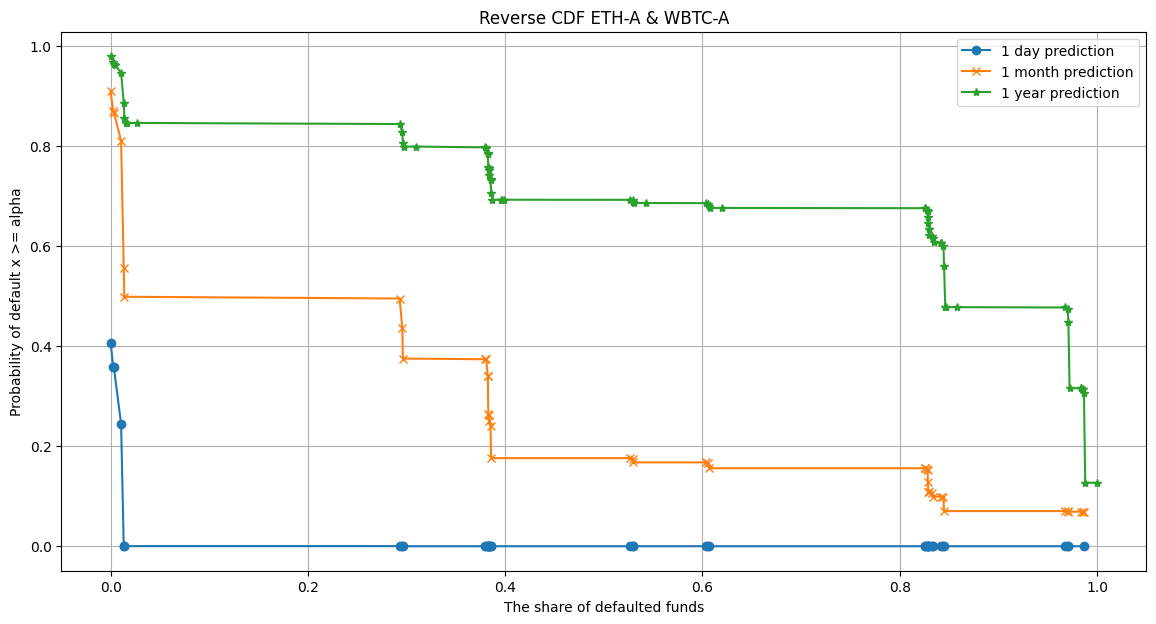

In [56]:
fig = plt.figure(figsize=(14, 7)) 
plt.plot(list(day_reverse_cdf.keys()), list(day_reverse_cdf.values()), label = '1 day prediction', marker = 'o')
plt.plot(list(month_reverse_cdf.keys()), list(month_reverse_cdf.values()), label = '1 month prediction', marker = 'x')
plt.plot(list(year_reverse_cdf.keys()), list(year_reverse_cdf.values()), label = '1 year prediction', marker = '*')
# plt.plot(list(avg_time_dict.keys()), list(avg_time_dict.values()), label = 'avg debt duration prediction', marker = '>')

# plt.yscale('log')
# plt.xscale('log')

plt.legend()
plt.grid()

plt.xlabel('The share of defaulted funds')
plt.ylabel('Probability of default x >= alpha')
plt.title('Reverse CDF ETH-A & WBTC-A')

plt.show()

### Define a day with the biggest sum of generate dai in both assets

In [63]:
def define_day_for_historical_cdf(df1, df2):    # df1 -- wbtc-a
    
    df1 = df1.sort_values(by=['timestamp'])
    df2 = df2.sort_values(by=['timestamp'])
    df2 = df2[pd.to_datetime(df2['timestamp_new']) >= pd.to_datetime(df1.iloc[0].timestamp_new)]

    sum_debt = 0
    sum_debt_tmp = 0
    choosen_day = None
    for day in df1.timestamp_new.unique():
        df1_tmp = df1[(df1['timestamp_new'] == day) & (df1['user_action']=='generate dai')]
        df2_tmp = df2[(df2['timestamp_new'] == day) & (df2['user_action']=='generate dai')]
        
        sum_debt_tmp = np.sum(df1_tmp.dai) + np.sum(df2_tmp.dai)

        if sum_debt < sum_debt_tmp:
            sum_debt = sum_debt_tmp
            choosen_day = day
    
    return df1[df1['timestamp_new'] == choosen_day], df2[df2['timestamp_new'] == choosen_day]


In [64]:
df_wbtc_def_day, df_eth_def_day = define_day_for_historical_cdf(df_wbtc_a_without_nan, df_eth_a_without_nan)

In [68]:
cond1 = df_eth_def_day['timestamp'] >= '2021-11-08 02:55:52+00:00'
cond2 = df_eth_def_day['timestamp'] <= '2021-11-08 03:16:40+00:00'
df_eth_def_day = df_eth_def_day[cond1&cond2]

In [69]:
cond1 = df_wbtc_def_day['timestamp'] >= '2021-11-08 03:00:57+00:00'
cond2 = df_wbtc_def_day['timestamp'] <= '2021-11-08 03:09:52+00:00'
df_wbtc_def_day = df_wbtc_def_day[cond1&cond2]

In [70]:
cols = df_wbtc_def_day.columns
df_wbtc_unique_users = pd.DataFrame(columns=cols)
for user in df_wbtc_def_day.usr.unique():
    df_wbtc_unique_users.loc[-1] =  df_wbtc_def_day[df_wbtc_def_day['usr'] == user].iloc[-1]
    df_wbtc_unique_users.index = df_wbtc_unique_users.index + 1
    df_wbtc_unique_users = df_wbtc_unique_users.sort_index()

cols = df_eth_def_day.columns
df_eth_unique_users = pd.DataFrame(columns=cols)
for user in df_eth_def_day.usr.unique():
    df_eth_unique_users.loc[-1] =  df_eth_def_day[df_eth_def_day['usr'] == user].iloc[-1]
    df_eth_unique_users.index = df_eth_unique_users.index + 1
    df_eth_unique_users = df_eth_unique_users.sort_index()

In [73]:
df_wbtc_unique_users.to_csv('df_wbtc_unique_users.csv')
df_eth_unique_users.to_csv('df_eth_unique_users.csv')

In [10]:
df_wbtc_unique_users = pd.read_csv('df_wbtc_unique_users.csv')
df_eth_unique_users = pd.read_csv('df_eth_unique_users.csv')

In [74]:
wbtc_usd_rate = wbtc_usd_rate[(pd.to_datetime(wbtc_usd_rate['snapped_at']) >= pd.to_datetime('2020-11-07 00:00:00 UTC')) & ( pd.to_datetime(wbtc_usd_rate['snapped_at']) <= pd.to_datetime('2021-11-07 00:00:00 UTC'))]
eth_usd_rate = eth_usd_rate[(pd.to_datetime(eth_usd_rate['snapped_at']) >= pd.to_datetime('2020-11-07 00:00:00 UTC')) & ( pd.to_datetime(eth_usd_rate['snapped_at']) <= pd.to_datetime('2021-11-07 00:00:00 UTC'))]

rho = rho_calculation(eth_usd_rate, wbtc_usd_rate)

In [81]:
def dict_x_min_debt_creation(df):

    res = {}
    for i in range(df.shape[0]):
        row = df.iloc[i]
        res[row.x_min] = row.debt
    
    res = dict(sorted(res.items()))
    return res, np.sum(list(res.values()))



dict_wbtc_def_day, overall_debt_wbtc_def_day = dict_x_min_debt_creation(df_wbtc_unique_users)
dict_eth_def_day, overall_debt_eth_def_day = dict_x_min_debt_creation(df_eth_unique_users)




def calculate_joint_prob(y, x, overall_debt_1, overall_debt_2, rho, T):
    
    res = {}
    additional_default_1 = np.sum(np.where(np.array(list(x.keys()))<0, np.array(list(x.values())), 0))      # it means that there is always user who default
    additional_default_2 = np.sum(np.where(np.array(list(y.keys()))<0, np.array(list(y.values())), 0))

    def delete_negative_x_min(x_min_arr):
        for key in list(x_min_arr.keys()):
            if key < 0:
                x_min_arr.pop(key)
        return x_min_arr
    
    x = delete_negative_x_min(x)
    y = delete_negative_x_min(y)

    for k in tqdm(range(-1, len(x), 1)):
        default_money_1 = 0
        a, b, c, d = 0, 0, 0, 0

        if k == -1:
            a = 0
            b = list(x.keys())[0]
        elif k == len(x) - 1:
            a = list(x.keys())[k]
            b = list(x.keys())[k] + 10
            default_money_1 = np.sum(list(x.values())) + additional_default_1
        else:
            a = list(x.keys())[k] 
            b = list(x.keys())[k+1]
            default_money_1 = np.sum(list(x.values())[:k]) + additional_default_1

        for l in range(-1, len(y), 1):
            default_money_2 = 0

            if l == -1:
                c = 0
                d = list(y.keys())[0]
            elif l == len(y) - 1:
                c = list(y.keys())[l]
                d = list(y.keys())[l] + 10
                default_money_2 = np.sum(list(y.values())) + additional_default_2
            else:
                c = list(y.keys())[l]
                d = list(y.keys())[l+1]
                default_money_2 = np.sum(list(y.values())[:l]) + additional_default_2
            
            overall_default = (default_money_1 + default_money_2) / (overall_debt_1 + overall_debt_2)
            print("Overall default debt: ", overall_default)

            print('a: ', a)
            print('b: ', b)
            print('c: ', c)
            print('d: ', d)
            if (a < 0) | (b < 0) | (c < 0) | (d < 0):
                # res[overall_default] = 1
                continue

            # T = 1.0
            print('BEGIN INTEGRATE')
            warnings.filterwarnings('error', category=RuntimeWarning)
            foo = lambda x_min1, x_min2: calculate_probability(rho, x_min1, x_min2, T)
            diff = MixedDerivative(foo)

            try:
                val, err = integrate.dblquad(diff.approx_derivative, a, b, c, d)
                # if val < 0:
                #     print('val: ', val)
                #     print('err: ', err)
                #     val += err
                if val < 0:
                    val = 1.0e-15
                    
                if overall_default in res:
                    res[overall_default] += val
                else:
                    res[overall_default] = val
                print("Integral result:", val)
                
            except RuntimeWarning as e:
                print(f"A runtime warning occurred: {e}")
            except Exception as e:
                print(f"An exception occurred: {e}")
            
            warnings.filterwarnings('default', category=RuntimeWarning)

            # print('PROBABILITY: ', val)
            print('END INTEGRATE')
    return dict(sorted(res.items()))

In [ ]:
day_def_day = calculate_joint_prob(dict_wbtc_def_day, dict_eth_def_day, overall_debt_wbtc_def_day, overall_debt_eth_def_day, rho, T=1)

In [77]:
d = {'share': list(day_def_day.keys()), 'probability': list(day_def_day.values())}
pd.DataFrame(data=d).to_csv('joint_prob_def_day_day.csv')

In [ ]:
month_def_day = calculate_joint_prob(dict_wbtc_def_day, dict_eth_def_day, overall_debt_wbtc_def_day, overall_debt_eth_def_day, rho, T=30)

In [80]:
d = {'share': list(month_def_day.keys()), 'probability': list(month_def_day.values())}
pd.DataFrame(data=d).to_csv('joint_prob_def_day_month.csv')

In [ ]:
year_def_day = calculate_joint_prob(dict_wbtc_def_day, dict_eth_def_day, overall_debt_wbtc_def_day, overall_debt_eth_def_day, rho, T=365)


In [83]:
d = {'share': list(year_def_day.keys()), 'probability': list(year_def_day.values())}
pd.DataFrame(data=d).to_csv('joint_prob_def_day_year.csv')

In [38]:
day_def_day = pd.read_csv('joint_prob_def_day_day.csv')
month_def_day = pd.read_csv('joint_prob_def_day_month.csv')
year_def_day = pd.read_csv('joint_prob_def_day_year.csv')

In [39]:
day_def_day = pd.Series(day_def_day['probability'].values, index=day_def_day['share']).to_dict()
month_def_day = pd.Series(month_def_day['probability'].values, index=month_def_day['share']).to_dict()
year_def_day = pd.Series(year_def_day['probability'].values, index=year_def_day['share']).to_dict()

In [84]:
day_reverse_cdf_hist = calculate_reverse_cdf(day_def_day)
month_reverse_cdf_hist = calculate_reverse_cdf(month_def_day)
year_reverse_cdf_hist = calculate_reverse_cdf(year_def_day)

In [85]:
day_cdf_hist = calculate_cdf(day_def_day)
month_cdf_hist = calculate_cdf(month_def_day)
year_cdf_hist = calculate_cdf(year_def_day)

In [58]:
d = {'share': list(day_cdf_hist.keys()), 'probability': list(day_cdf_hist.values())}
pd.DataFrame(data=d).to_csv('cdf_prob_def_day_day.csv')

d = {'share': list(month_cdf_hist.keys()), 'probability': list(month_cdf_hist.values())}
pd.DataFrame(data=d).to_csv('cdf_prob_def_day_month.csv')

d = {'share': list(year_cdf_hist.keys()), 'probability': list(year_cdf_hist.values())}
pd.DataFrame(data=d).to_csv('cdf_prob_def_day_year.csv')

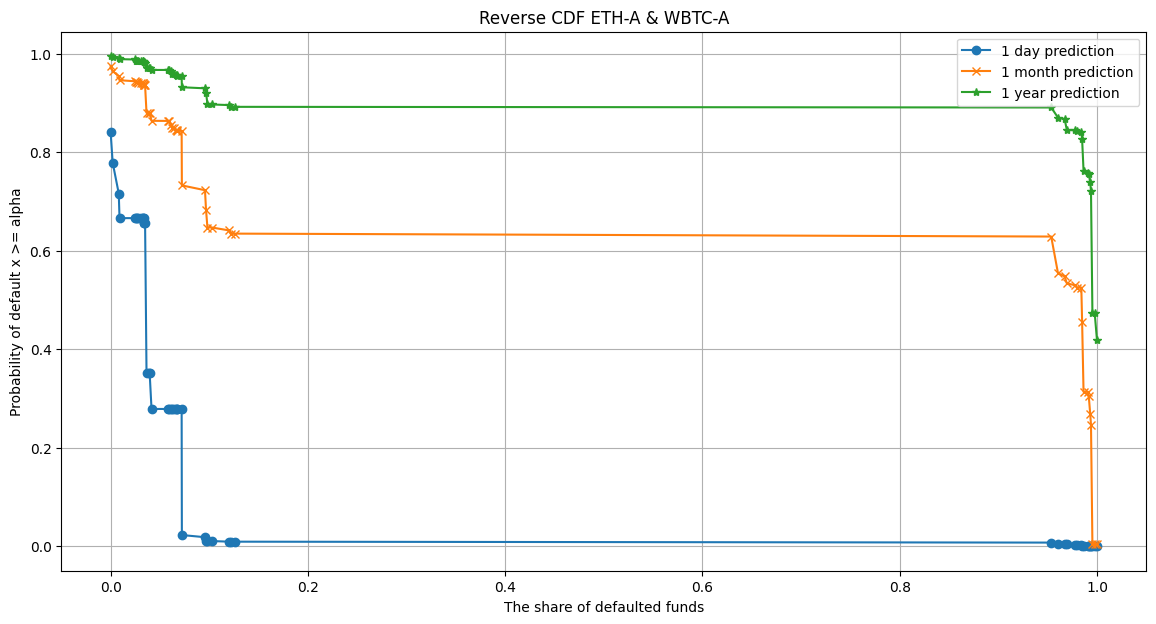

In [86]:
fig = plt.figure(figsize=(14, 7)) 
plt.plot(list(day_reverse_cdf_hist.keys()), list(day_reverse_cdf_hist.values()), label = '1 day prediction', marker = 'o')
plt.plot(list(month_reverse_cdf_hist.keys()), list(month_reverse_cdf_hist.values()), label = '1 month prediction', marker = 'x')
plt.plot(list(year_reverse_cdf_hist.keys()), list(year_reverse_cdf_hist.values()), label = '1 year prediction', marker = '*')
# plt.plot(list(avg_time_dict.keys()), list(avg_time_dict.values()), label = 'avg debt duration prediction', marker = '>')

# plt.yscale('log')
# plt.xscale('log')

plt.legend()
plt.grid()

plt.xlabel('The share of defaulted funds')
plt.ylabel('Probability of default x >= alpha')
plt.title('Reverse CDF ETH-A & WBTC-A')

plt.show()

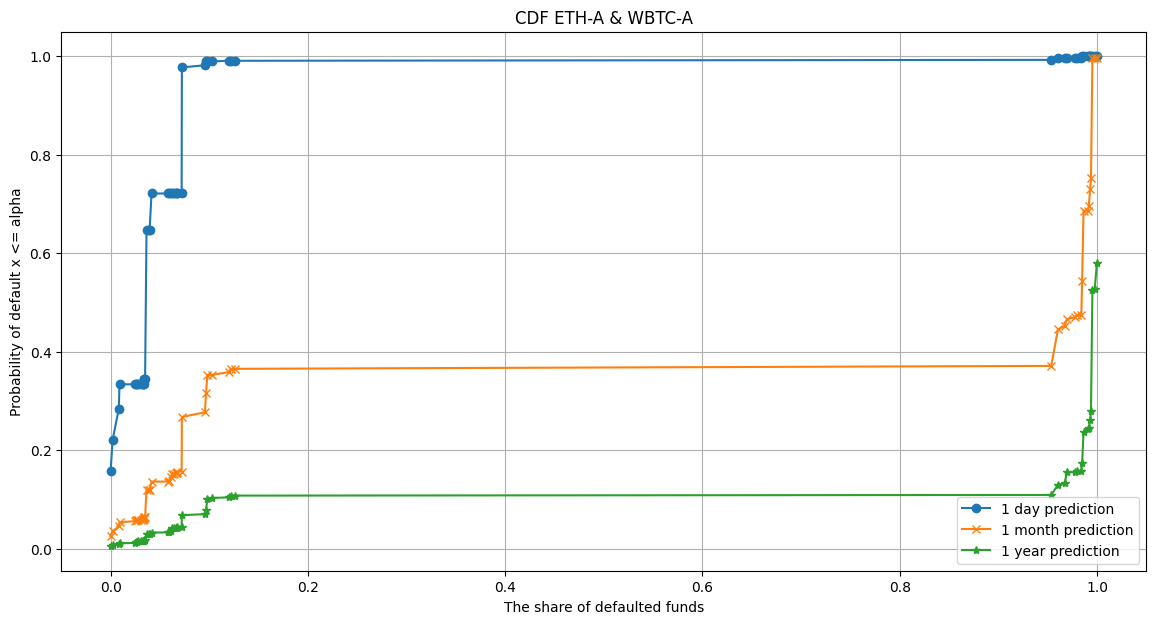

In [87]:
fig = plt.figure(figsize=(14, 7)) 
plt.plot(list(day_cdf_hist.keys()), list(day_cdf_hist.values()), label = '1 day prediction', marker = 'o')
plt.plot(list(month_cdf_hist.keys()), list(month_cdf_hist.values()), label = '1 month prediction', marker = 'x')
plt.plot(list(year_cdf_hist.keys()), list(year_cdf_hist.values()), label = '1 year prediction', marker = '*')
# plt.plot(list(avg_time_dict.keys()), list(avg_time_dict.values()), label = 'avg debt duration prediction', marker = '>')

# plt.yscale('log')
# plt.xscale('log')

plt.legend()
plt.grid()

plt.xlabel('The share of defaulted funds')
plt.ylabel('Probability of default x <= alpha')
plt.title('CDF ETH-A & WBTC-A')

plt.show()